# QCBM-based Path Simulation
Based on papers: https://arxiv.org/pdf/2204.06150, https://arxiv.org/html/2405.11795v1#Sx2.F4


In [ ]:
import pennylane as qml
from pennylane import numpy as pnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


total_qubits = 8  
layers = 7  
dev = qml.device("default.qubit", wires=total_qubits)


def brick_ansatz(params):
    """Standard Brick QCBM ."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(total_qubits - 1):  
            qml.CNOT(wires=[i, i + 1])  
    return qml.probs(wires=range(total_qubits))

def butterfly_ansatz(params):
    """Butterfly Ansatz."""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        
        step = 1
        while step < total_qubits:  # Logarithmic-depth entanglement pattern
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))


def pyramid_ansatz(params):
    """Pyramid Ansatz: Progressive entanglement """
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)

        # Progressive entanglement: more CNOTs as depth increases
        step = 1
        for _ in range(l + 1):  # Increase connectivity as layers grow
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2  # Increase entanglement range per layer
    return qml.probs(wires=range(total_qubits))

def tree_ansatz(params):
    """Binary Tree Entanglement ansatz"""
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        step = 1
        while step < total_qubits:  # Hierarchical CNOT entanglement
            for i in range(0, total_qubits - step, 2 * step):
                qml.CNOT(wires=[i, i + step])
            step *= 2
    return qml.probs(wires=range(total_qubits))

def star_ansatz(params):
    """Star entanglement ansatz with a central hub qubit."""
    hub = 0  # Central qubit
    for l in range(layers):
        for i in range(total_qubits):
            qml.RX(params[l, i, 0], wires=i)
            qml.RY(params[l, i, 1], wires=i)
            qml.RZ(params[l, i, 2], wires=i)
        for i in range(1, total_qubits):  # Hub qubit connects to all others
            qml.CNOT(wires=[hub, i])
    return qml.probs(wires=range(total_qubits))




# def rbs_gate(theta, wires):
#     """RBS gate."""
#     qml.RY(theta, wires=wires[0])
#     qml.CNOT(wires=wires)
#     qml.RY(-theta, wires=wires[0])
#     qml.CNOT(wires=wires)

# def pyramid_ansatz(params):
#     """Pyramid ansatz using RBS gates."""
#     qubits = params.shape[1]  
#     for l in range(params.shape[0]):  
#         step = 1
#         while step < qubits:
#             for i in range(0, qubits - step, 2 * step):
#                 rbs_gate(params[l, i, 0], wires=[i, i + step])
#             step *= 2  # Increase step size in powers of 2
#     return qml.probs(wires=range(qubits))



@qml.qnode(dev, diff_method="parameter-shift")
def quantum_model(params):
    return butterfly_ansatz(params)


In [ ]:
def kl_divergence(p, q):
    p = pnp.where(p == 0, 1e-10, p)
    q = pnp.where(q == 0, 1e-10, q)
    return pnp.sum(p * pnp.log(p / q))


def gaussian_kernel(x, y, sigma=1.0):
    return np.exp(-np.linalg.norm(x - y) ** 2 / (2 * sigma ** 2))

def mmd(x, y, sigma=1.0):
    xx, yy, xy = 0, 0, 0
    for i in range(len(x)):
        for j in range(len(x)):
            xx += gaussian_kernel(x[i], x[j], sigma)
            yy += gaussian_kernel(y[i], y[j], sigma)
            xy += gaussian_kernel(x[i], y[j], sigma)
    return xx / (len(x) ** 2) + yy / (len(y) ** 2) - 2 * xy / (len(x) * len(y))
    

def cost(params):
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(training_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)


def load_and_preprocess_data(file_path):
    data = pd.read_csv(file_path)
    prices = pd.to_numeric(data['Price'].str.replace(',', ''), errors='coerce').dropna().values 
    if len(prices) == 0:
        raise ValueError("No valid price data found in the file.")
    log_returns = np.diff(np.log(prices))
    if len(log_returns) == 0:
        raise ValueError("Log returns array is empty.")
    bins = np.linspace(min(log_returns), max(log_returns), 2**total_qubits)
    return log_returns, np.digitize(log_returns, bins) - 1, bins


log_returns, training_data, bins = load_and_preprocess_data('StoxxLarger.csv')


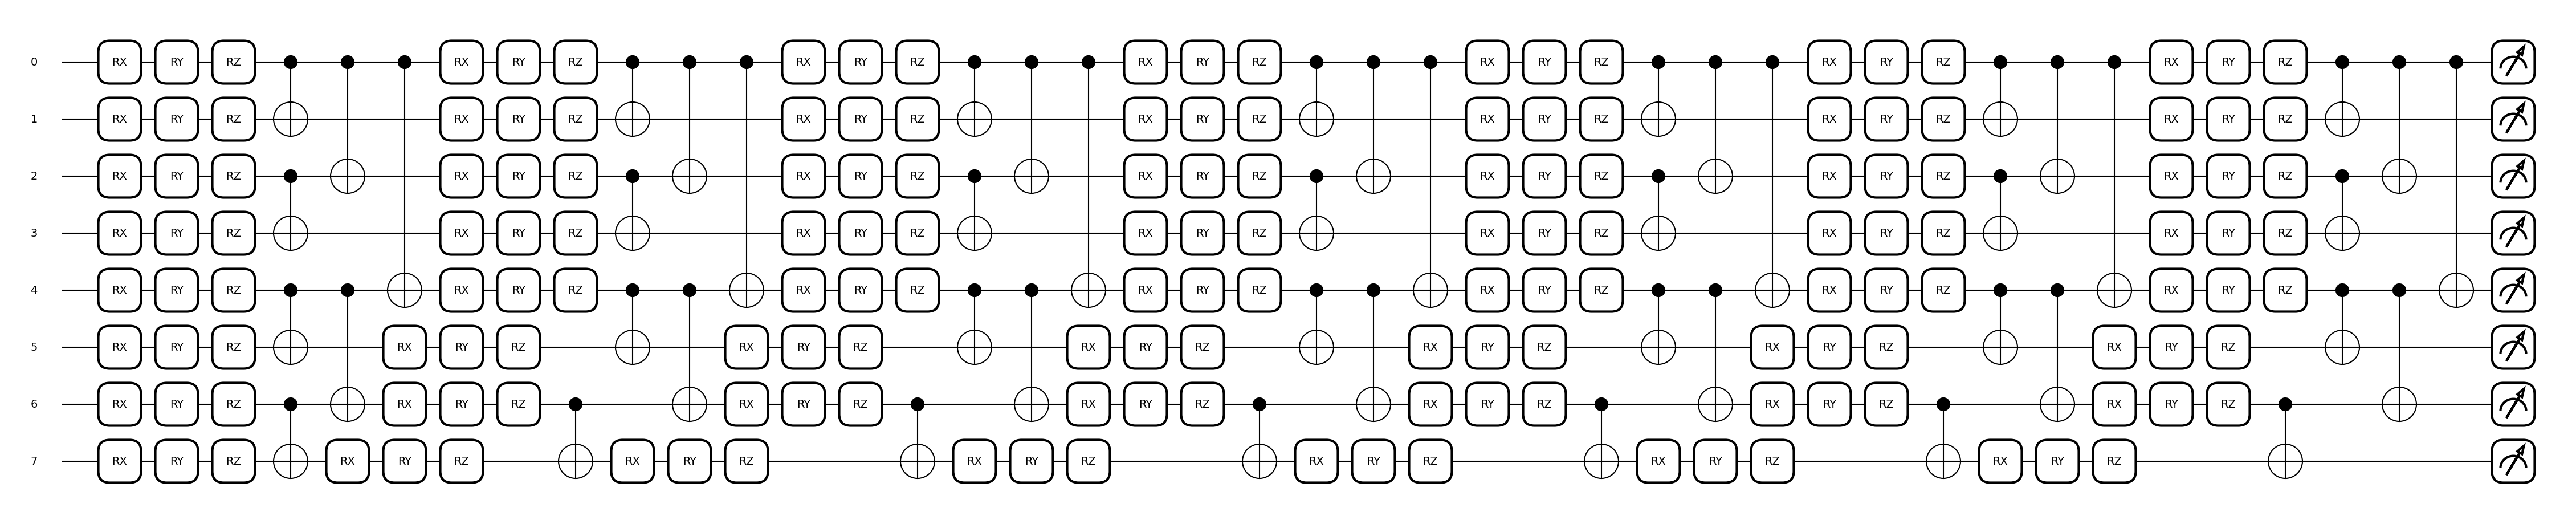

In [47]:
opt = qml.AdamOptimizer(stepsize=0.05)
params = pnp.array(np.random.uniform(0, np.pi, (layers, total_qubits, 3)), requires_grad=True)

qml.draw_mpl(quantum_model)(params)
plt.show()



In [ ]:
steps_training = 200

for i in range(steps_training):
    params = opt.step(cost, params)
    if i % 10 == 0:
        print(f"Step {i}: Cost = {cost(params)}")




Step 0: Cost = 1.524096116021194
Step 10: Cost = 0.5111664022148158
Step 20: Cost = 0.2505070718501884
Step 30: Cost = 0.17498518406441024
Step 40: Cost = 0.13459445005725673
Step 50: Cost = 0.1146602541962017
Step 60: Cost = 0.09920137286294703
Step 70: Cost = 0.09076695499876322
Step 80: Cost = 0.08717717317081704
Step 90: Cost = 0.08476156936488222
Step 100: Cost = 0.08198635676438643
Step 110: Cost = 0.07890183413570452
Step 120: Cost = 0.07541388944625887
Step 130: Cost = 0.07269770462193993
Step 140: Cost = 0.07090336593286323
Step 150: Cost = 0.06945224310211708
Step 160: Cost = 0.06825374577316459
Step 170: Cost = 0.06720789935480237
Step 180: Cost = 0.06621825554629045
Step 190: Cost = 0.06509422137296696


In [49]:
print(params)

[[[ 0.51378059  0.28171488  1.37125883]
  [ 1.43650253  2.92372695  1.74437194]
  [ 1.0199209   2.72371602  2.75931804]
  [ 1.14290011  3.34650561  1.95060181]
  [ 2.19065451  2.47948549  1.76365408]
  [ 2.2614329   1.38755979  2.38138265]
  [ 2.68190309  1.30365937  0.1784562 ]
  [ 1.92695259  3.45532536  1.58942775]]

 [[ 2.40092708  2.56375489  0.41135328]
  [ 0.76924392  1.54559956  1.50730363]
  [ 2.39258765  2.4394532   2.99827855]
  [ 1.27123594  2.29397664  1.46614919]
  [ 2.19162274  1.8749678   0.68921328]
  [ 2.40100284  1.80348774  3.12484036]
  [ 0.20317757  1.40425369  1.34799173]
  [ 2.71297244  0.84857096  0.70125871]]

 [[ 3.1994079   3.17416654  1.7700069 ]
  [ 3.05642866  2.17967084 -0.27465631]
  [ 0.99177057  0.16766234  1.80174305]
  [ 2.69473659  1.30133839  2.14471623]
  [ 0.36514284  1.5577799   2.31685605]
  [ 0.01725551  1.42069099  1.66715922]
  [ 0.8826641   0.27225296  1.48704588]
  [ 2.62700368  0.96680472  1.83699399]]

 [[ 0.00541801 -0.07456577  0.1162

In [ ]:
import torch

def save_params(params, file_path):
    # Convert all tensors to lists
    def convert_tensors(obj):
        if isinstance(obj, torch.Tensor):
            return obj.tolist()
        elif isinstance(obj, dict):
            return {k: convert_tensors(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [convert_tensors(i) for i in obj]
        return obj

    params = convert_tensors(params)

    with open(file_path, 'w') as file:
        if isinstance(params, dict):
            for key, value in params.items():
                file.write(f"{key}: {value}\n")
        else:
            for item in params:
                file.write(f"{item}\n")

def load_params(file_path):
    with open(file_path, 'r') as file:
        content = file.read().strip()
    
    # Convert string back to list
    content = content.replace('\n', ', ')
    content = f"[{content}]"
    params = eval(content)
    
    # Convert lists back to tensors if necessary
    def convert_lists(obj):
        if isinstance(obj, list):
            return torch.tensor(obj)
        elif isinstance(obj, dict):
            return {k: convert_lists(v) for k, v in obj.items()}
        return obj

    params = convert_lists(params)
    
    return params



save_params(params, 'params.txt')
#loaded_params = load_params_from_file('params.txt')
#print(loaded_params)

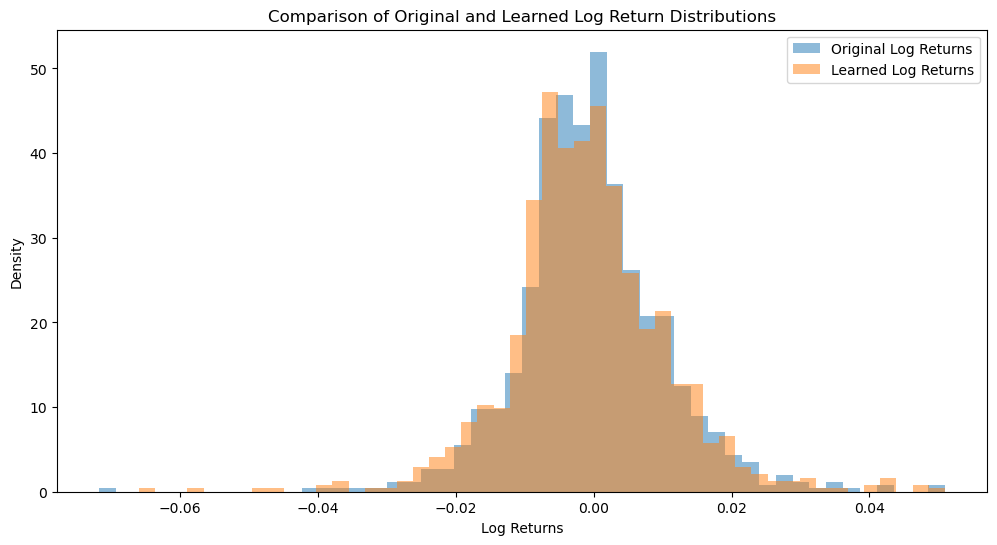

In [ ]:
#synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))
def generate_synthetic_log_returns(params, bins, steps=100):
    quantum_probs = quantum_model(params)
    sampled_indices = np.random.choice(len(quantum_probs), p=quantum_probs, size=steps)
    return bins[sampled_indices]

synthetic_log_returns = generate_synthetic_log_returns(params, bins, len(log_returns))

plt.figure(figsize=(12, 6))
plt.hist(log_returns, bins=50, alpha=0.5, label='Original Log Returns', density=True)
plt.hist(synthetic_log_returns, bins=50, alpha=0.5, label='Learned Log Returns', density=True)
plt.xlabel('Log Returns')
plt.ylabel('Density')
plt.title('Comparison of Original and Learned Log Return Distributions')
plt.legend()
plt.show()

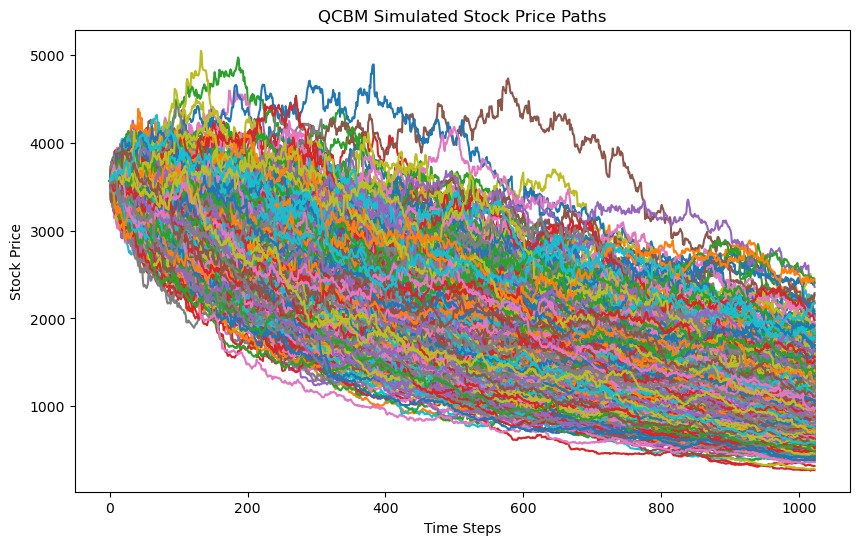

In [52]:


def simulate_stochastic_path(params, bins, steps=100, start_value=100):
    log_returns = generate_synthetic_log_returns(params, bins, steps)
    S = np.zeros(steps)
    S[0] = 3564.63  # Starting value
    for t in range(1, steps):
        S[t] = S[t - 1] * np.exp(log_returns[t])
    return S

# Propagate the learned stochastic process
def propagate_stochastic_process(params, bins, num_paths=10, steps=100):
    paths = []
    for _ in range(num_paths):
        path = simulate_stochastic_path(params, bins, steps)
        paths.append(path)
    return np.array(paths)


num_paths = 1000
steps = 256*4
paths = propagate_stochastic_process(params, bins, num_paths, steps)


plt.figure(figsize=(10, 6))
for i, path in enumerate(paths):
    plt.plot(path, label=f'Path {i+1}')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.title('QCBM Simulated Stock Price Paths')
plt.show()

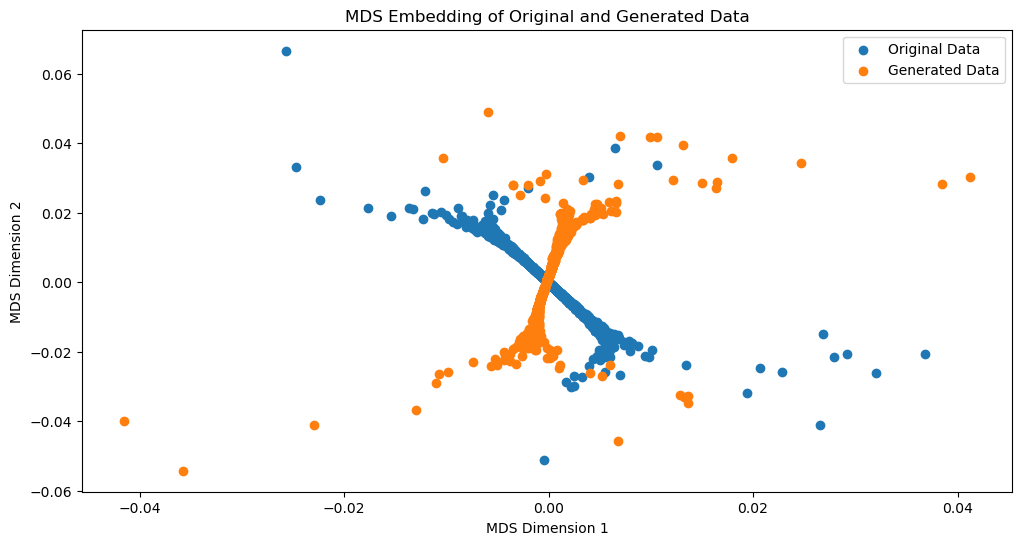

In [53]:
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

original_distances = pairwise_distances(log_returns.reshape(-1, 1))
generated_distances = pairwise_distances(synthetic_log_returns.reshape(-1, 1))

mds = MDS(n_components=2, dissimilarity='precomputed')
original_mds = mds.fit_transform(original_distances)
generated_mds = mds.fit_transform(generated_distances)

plt.figure(figsize=(12, 6))
plt.scatter(original_mds[:, 0], original_mds[:, 1], label='Original Data')
plt.scatter(generated_mds[:, 0], generated_mds[:, 1], label='Generated Data')
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('MDS Embedding of Original and Generated Data')
plt.legend()

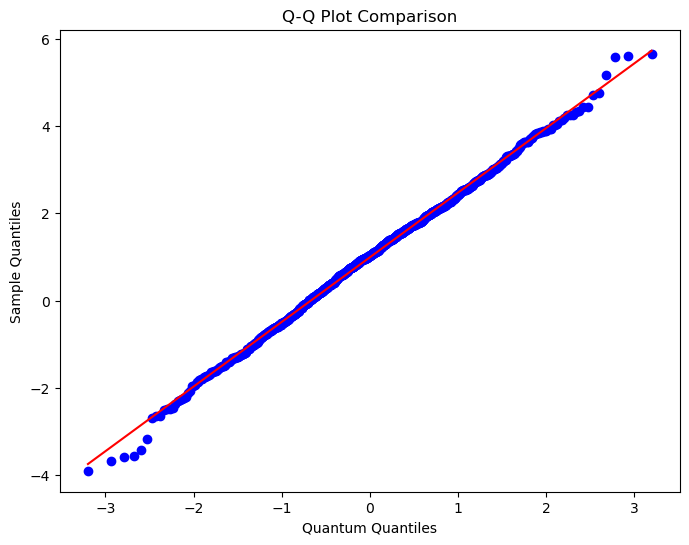

In [ ]:
import scipy.stats as stats

real_data = np.random.normal(loc=0, scale=1, size=1000)
quantum_generated_data = np.random.normal(loc=1, scale=1.5, size=1000)


plt.figure(figsize=(8, 6))
#stats.probplot(real_data, dist="norm", plot=plt)
stats.probplot(quantum_generated_data, dist="norm", plot=plt)

plt.xlabel('Quantum Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot Comparison')
plt.show()

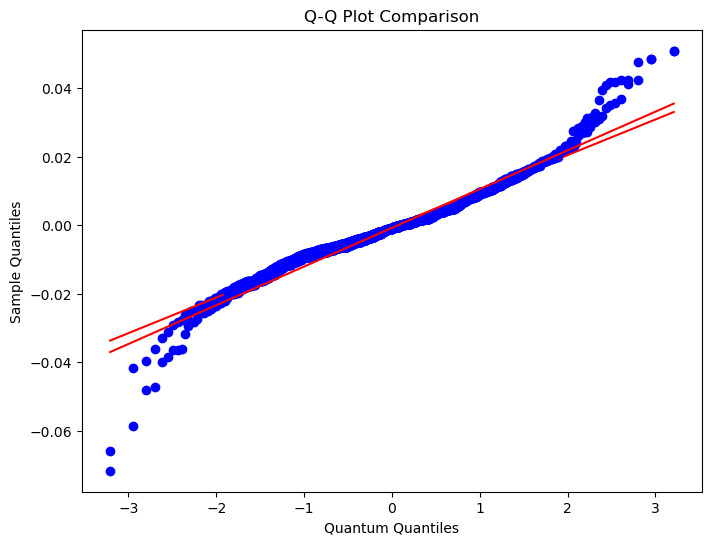

In [70]:
# use a qq plot to compare the distribution of the original data to the generated data
plt.figure(figsize=(8, 6))
stats.probplot(log_returns, dist="norm", plot=plt)
stats.probplot(synthetic_log_returns, dist="norm", plot=plt)
plt.xlabel('Quantum Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot Comparison')
plt.show()


4.04577726518059


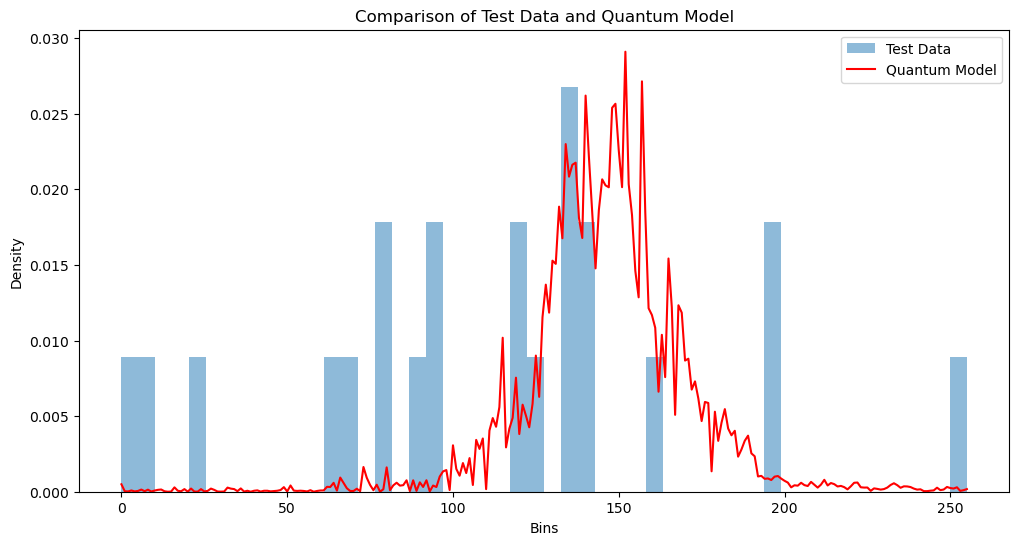

In [ ]:
def compare_to_data(params, file_path):
    log_returns, test_data, _ = load_and_preprocess_data(file_path)
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(test_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs, quantum_probs)

print(compare_to_data(params, 'StoxxTest.csv'))



def plot_data_and_model(params, file_path):
    log_returns, test_data, _ = load_and_preprocess_data(file_path)
    quantum_probs = quantum_model(params)
    plt.figure(figsize=(12, 6))
    plt.hist(test_data, bins=50, alpha=0.5, label='Test Data', density=True)
    plt.plot(quantum_probs, label='Quantum Model', color='red')
    plt.xlabel('Bins')
    plt.ylabel('Density')
    plt.title('Comparison of Test Data and Quantum Model')
    plt.legend()
    plt.show()



plot_data_and_model(params, 'StoxxTest.csv')

In [ ]:
def tail_adequacy_test(params, file_path):
    log_returns, test_data, _ = load_and_preprocess_data(file_path)
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(test_data, bins=len(quantum_probs), density=True)[0]
    return kl_divergence(empirical_probs[:10], quantum_probs[:10]) + kl_divergence(empirical_probs[-10:], quantum_probs[-10:])

print(tail_adequacy_test(params, 'StoxxTest.csv'))

0.46108980994817583


In [ ]:
def ks_test(params, file_path):
    log_returns, test_data, _ = load_and_preprocess_data(file_path)
    quantum_probs = quantum_model(params)
    empirical_probs = np.histogram(test_data, bins=len(quantum_probs), density=True)[0]
    return stats.ks_2samp(empirical_probs[:10], quantum_probs[:10]).statistic + stats.ks_2samp(empirical_probs[-10:], quantum_probs[-10:]).statistic

print(ks_test(params, 'StoxxTest.csv'))

1.8
